<a href="https://colab.research.google.com/github/tankTopTaro/Deep-Learning-with-Python/blob/main/06_Transfer_Learning_with_TensorFlow_Part_3_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow: Scaling Up (🍔👀 Food Vision Mini)

🥅 **Goal:** Beat the [original Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) with 10% of the training. Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
!nvidia-smi

Sat Oct  8 19:42:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Download helper functions
!wget https://raw.githubusercontent.com/tankTopTaro/Deep-Learning-with-Python/main/helper_functions/helper_functions.py

--2022-10-08 19:42:55--  https://raw.githubusercontent.com/tankTopTaro/Deep-Learning-with-Python/main/helper_functions/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10235 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    in 0s      

2022-10-08 19:42:55 (81.1 MB/s) - ‘helper_functions.py’ saved [10235/10235]



In [3]:
# Import series of helper function
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

The data comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 
unzip_data('101_food_classes_10_percent.zip')

# Set dataset directories
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2022-10-08 19:42:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.211.128, 173.194.212.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.211.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   193MB/s    in 7.2s    

2022-10-08 19:43:05 (215 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/deviled_eggs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/clam_chowder'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_cheese_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pho'.
There are 0 directories and 250 imag

In [6]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE,
    shuffle = False # don't shuffle test data for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


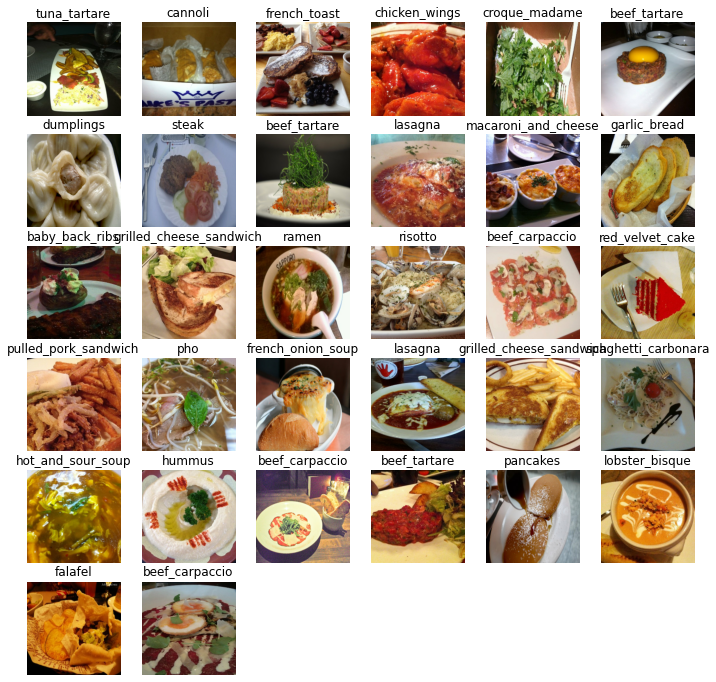

In [7]:
# Visualize images
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))
class_names = train_data_all_10_percent.class_names

for images, labels in train_data_all_10_percent.take(1):
  for i in range(32):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis(False);

## Train a big dog model with transfer learning on 10% of Food101 food classes

1. Create a ModelCheckpoint callback
2. Create a data augmentation layer to build data augmentation right into the model
3. Build a headless (no top layers) Functional EfficientNetB0 backboned-model (create our own output layer)
4. Compile the model
5. Feature extract for 5 full pass ( 5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

### Create a `ModelCheckpoint` callback

In [8]:
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    save_best_only = True
)

### Create data augmentation layer to incorporate it right into the model

In [9]:
from keras import layers
from keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name='data_augmentation')

### Build a headless functional EfficientNetB0 backboned-model

In [10]:
len(class_names)

101

In [11]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # puts the base model in inference mode so weights which need to stay frozen, stay frozen
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Compile the model and feature extract for 5 full passes

In [13]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

history_0 = model.fit(
    train_data_all_10_percent,
    epochs = 5,
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    callbacks = [create_tensorboard_callback('transfer learning', '10_percent_101_classes'), 
                 checkpoint_callback]
)

Saving TensorBoard log files to: transfer learning/10_percent_101_classes/20221008-194340
Epoch 1/5
237/237 [==============================] - 115s 424ms/step - loss: 3.4857 - accuracy: 0.2479 - val_loss: 2.6240 - val_accuracy: 0.4158
Epoch 2/5
237/237 [==============================] - 70s 294ms/step - loss: 2.3551 - accuracy: 0.4547 - val_loss: 2.2601 - val_accuracy: 0.4542
Epoch 3/5
237/237 [==============================] - 65s 273ms/step - loss: 1.9854 - accuracy: 0.5308 - val_loss: 2.0775 - val_accuracy: 0.4801
Epoch 4/5
237/237 [==============================] - 53s 223ms/step - loss: 1.7582 - accuracy: 0.5769 - val_loss: 1.9859 - val_accuracy: 0.4934
Epoch 5/5
237/237 [==============================] - 47s 197ms/step - loss: 1.5969 - accuracy: 0.6120 - val_loss: 1.9428 - val_accuracy: 0.4923


In [14]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 57s 72ms/step - loss: 1.7143 - accuracy: 0.5537


[1.7142571210861206, 0.5536633729934692]

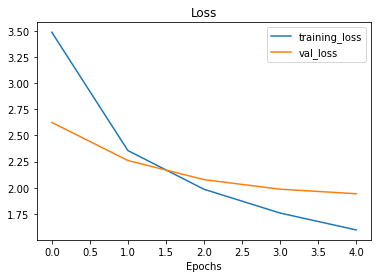

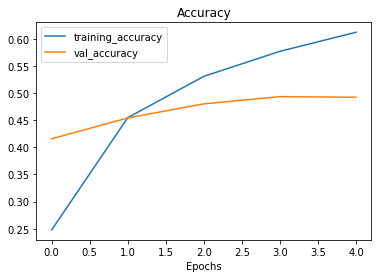

In [15]:
plot_loss_curves(history_0)

## Fine-tuning

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
# Which layers are trainable in the base model
for layer_number, layer in enumerate(model.layers[2].layers):
  if layer.trainable is True:
    print(layer_number, layer.name, layer.trainable)

232 block7a_project_conv True
233 block7a_project_bn True
234 top_conv True
235 top_bn True
236 top_activation True


In [19]:
# Recompile model with lower learning rate 
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)

In [20]:
# Refit the model
FINE_TUNE_EPOCHS = 10

history_1 = model.fit(
    train_data_all_10_percent,
    epochs = FINE_TUNE_EPOCHS,
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = history_0.epoch[-1],
    callbacks = [create_tensorboard_callback('transfer learning', '10_percent_101_classes_fine_tuned')]
)

Saving TensorBoard log files to: transfer learning/10_percent_101_classes_fine_tuned/20221008-195205
Epoch 5/10
237/237 [==============================] - 57s 210ms/step - loss: 1.3492 - accuracy: 0.6548 - val_loss: 1.9141 - val_accuracy: 0.5034
Epoch 6/10
237/237 [==============================] - 44s 185ms/step - loss: 1.2318 - accuracy: 0.6763 - val_loss: 1.9001 - val_accuracy: 0.5077
Epoch 7/10
237/237 [==============================] - 43s 181ms/step - loss: 1.1598 - accuracy: 0.6935 - val_loss: 1.8419 - val_accuracy: 0.5169
Epoch 8/10
237/237 [==============================] - 43s 179ms/step - loss: 1.0692 - accuracy: 0.7184 - val_loss: 1.8861 - val_accuracy: 0.5156
Epoch 9/10
237/237 [==============================] - 52s 218ms/step - loss: 1.0237 - accuracy: 0.7287 - val_loss: 1.8118 - val_accuracy: 0.5270
Epoch 10/10
237/237 [==============================] - 41s 170ms/step - loss: 0.9696 - accuracy: 0.7419 - val_loss: 1.8188 - val_accuracy: 0.5294


In [21]:
feature_extraction_results

[1.7142571210861206, 0.5536633729934692]

In [22]:
fine_tuned_results = model.evaluate(test_data)
fine_tuned_results

790/790 [==============================] - 57s 72ms/step - loss: 1.6150 - accuracy: 0.5754


[1.6149822473526, 0.5753663182258606]

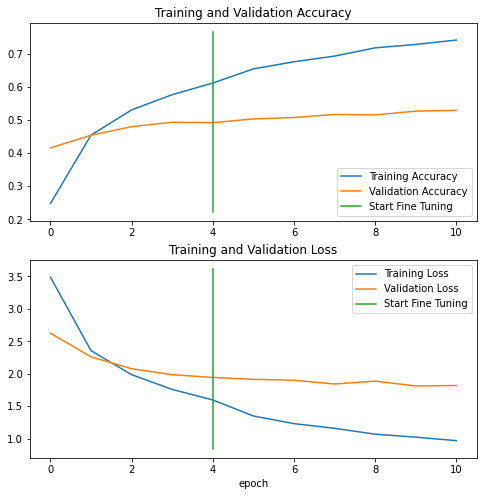

In [23]:
# Compare histories of feature extraction model with fine-tuning model
compare_historys(history_0, history_1)

## Saving and Loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [24]:
# Save out fine-tuning model
model.save('/content/drive/MyDrive/Saved_Model/101_food_classes_10_percent_saved_big_dog_model')

In [25]:
# Load saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Saved_Model/101_food_classes_10_percent_saved_big_dog_model')

In [26]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 70s 87ms/step - loss: 1.6150 - accuracy: 0.5754


[1.6149822473526, 0.5753663182258606]

In [27]:
fine_tuned_results

[1.6149822473526, 0.5753663182258606]

## Evaluating the performance of the big dog model across all different classes

🗒 **To Do:**
* make some predictions
* visualize them
* find out which predictions were the "most" wrong

In [28]:
import tensorflow as tf

# Download pretrained model (so all prediction are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-10-08 20:00:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.218.128, 108.177.11.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   137MB/s    in 0.3s    

2022-10-08 20:00:49 (137 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [29]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [30]:
# Load in saved model
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [31]:
# Evaluate loaded model
downloaded_model_results = model.evaluate(test_data)
downloaded_model_results

790/790 [==============================] - 59s 74ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

### Making predictions with our trained model

In [32]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 63s 78ms/step


In [33]:
len(test_data)

790

In [34]:
# How many predictions are there?
len(pred_probs)

25250

In [35]:
# What's the shape of our predictions
pred_probs.shape

(25250, 101)

In [36]:
# See what the first 10 predictions look like
pred_probs[:10]

array([[5.95419854e-02, 3.57419162e-06, 4.13769186e-02, ...,
        1.41387080e-09, 8.35307583e-05, 3.08974390e-03],
       [9.64016676e-01, 1.37532452e-09, 8.47806048e-04, ...,
        5.42870403e-05, 7.83623513e-12, 9.84662019e-10],
       [9.59258676e-01, 3.25336187e-05, 1.48669630e-03, ...,
        7.18911338e-07, 5.43971566e-07, 4.02759251e-05],
       ...,
       [4.73132670e-01, 1.29312113e-07, 1.48055935e-03, ...,
        5.97500475e-04, 6.69690999e-05, 2.34692561e-05],
       [4.45718728e-02, 4.72655188e-07, 1.22585356e-01, ...,
        6.34986191e-06, 7.53185031e-06, 3.67787969e-03],
       [7.24389434e-01, 1.92497285e-09, 5.23109811e-05, ...,
        1.22913765e-03, 1.57927704e-09, 9.63959174e-05]], dtype=float32)

In [37]:
# What does the first prediction probability array look like?
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([5.9541985e-02, 3.5741916e-06, 4.1376919e-02, 1.0660556e-09,
        8.1614289e-09, 8.6639496e-09, 8.0926748e-07, 8.5652420e-07,
        1.9859073e-05, 8.0977537e-07, 3.1727807e-09, 9.8673740e-07,
        2.8532124e-04, 7.8049200e-10, 7.4229989e-04, 3.8916456e-05,
        6.4740370e-06, 2.4977257e-06, 3.7891099e-05, 2.0678289e-07,
        1.5538439e-05, 8.1507034e-07, 2.6230571e-06, 2.0010687e-07,
        8.3827535e-07, 5.4216039e-06, 3.7390894e-06, 1.3150533e-08,
        2.7761445e-03, 2.8051867e-05, 6.8562417e-10, 2.5574856e-05,
        1.6688897e-04, 7.6407297e-10, 4.0452820e-04, 1.3150634e-08,
        1.7957362e-06, 1.4448203e-06, 2.3062892e-02, 8.2466704e-07,
        8.5365696e-07, 1.7138661e-06, 7.0525039e-06, 1.8402202e-08,
        2.8553322e-07, 7.9483461e-06, 2.0681496e-06, 1.8525083e-07,
        3.3619710e-08, 3.1522510e-04, 1.0410924e-05, 8.5448448e-07,
        8.4741873e-01, 1.0555446e-05, 4.4094710e-07, 3.7404185e-05,
        3.5306130e-05, 3.2489072e-05, 6.7314744e

Our model outputs a prediction array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [38]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9541985e-02 3.5741916e-06 4.1376919e-02 1.0660556e-09 8.1614289e-09
 8.6639496e-09 8.0926748e-07 8.5652420e-07 1.9859073e-05 8.0977537e-07
 3.1727807e-09 9.8673740e-07 2.8532124e-04 7.8049200e-10 7.4229989e-04
 3.8916456e-05 6.4740370e-06 2.4977257e-06 3.7891099e-05 2.0678289e-07
 1.5538439e-05 8.1507034e-07 2.6230571e-06 2.0010687e-07 8.3827535e-07
 5.4216039e-06 3.7390894e-06 1.3150533e-08 2.7761445e-03 2.8051867e-05
 6.8562417e-10 2.5574856e-05 1.6688897e-04 7.6407297e-10 4.0452820e-04
 1.3150634e-08 1.7957362e-06 1.4448203e-06 2.3062892e-02 8.2466704e-07
 8.5365696e-07 1.7138661e-06 7.0525039e-06 1.8402202e-08 2.8553322e-07
 7.9483461e-06 2.0681496e-06 1.8525083e-07 3.3619710e-08 3.1522510e-04
 1.0410924e-05 8.5448448e-07 8.4741873e-01 1.0555446e-05 4.4094710e-07
 3.7404185e-05 3.5306130e-05 3.2489072e-05 6.7314744e-05 1.2852592e-08
 2.6219760e-10 1.0318110e-05 8.5744046e-05 1.

In [39]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [40]:
# How many pred classes do we have
len(pred_classes)

25250

In [41]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
# How many y_labels are there?
len(y_labels)

25250

### Evaluating our model's predictions

One way to check that our model's predictions array is the same order as our test labels array is to find the accuracy score.

In [43]:
downloaded_model_results

[1.8027206659317017, 0.6077623963356018]

In [44]:
# Use scikit-learn accuracy score function
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(
    y_true = y_labels,
    y_pred = pred_classes
)

sklearn_accuracy

0.6077623762376237

In [45]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(downloaded_model_results[1], sklearn_accuracy)

True

#### Making a confusion matrix

In [46]:
from helper_functions import make_confusion_matrix

In [47]:
# Get a list of class names
class_names = test_data.class_names

In [48]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

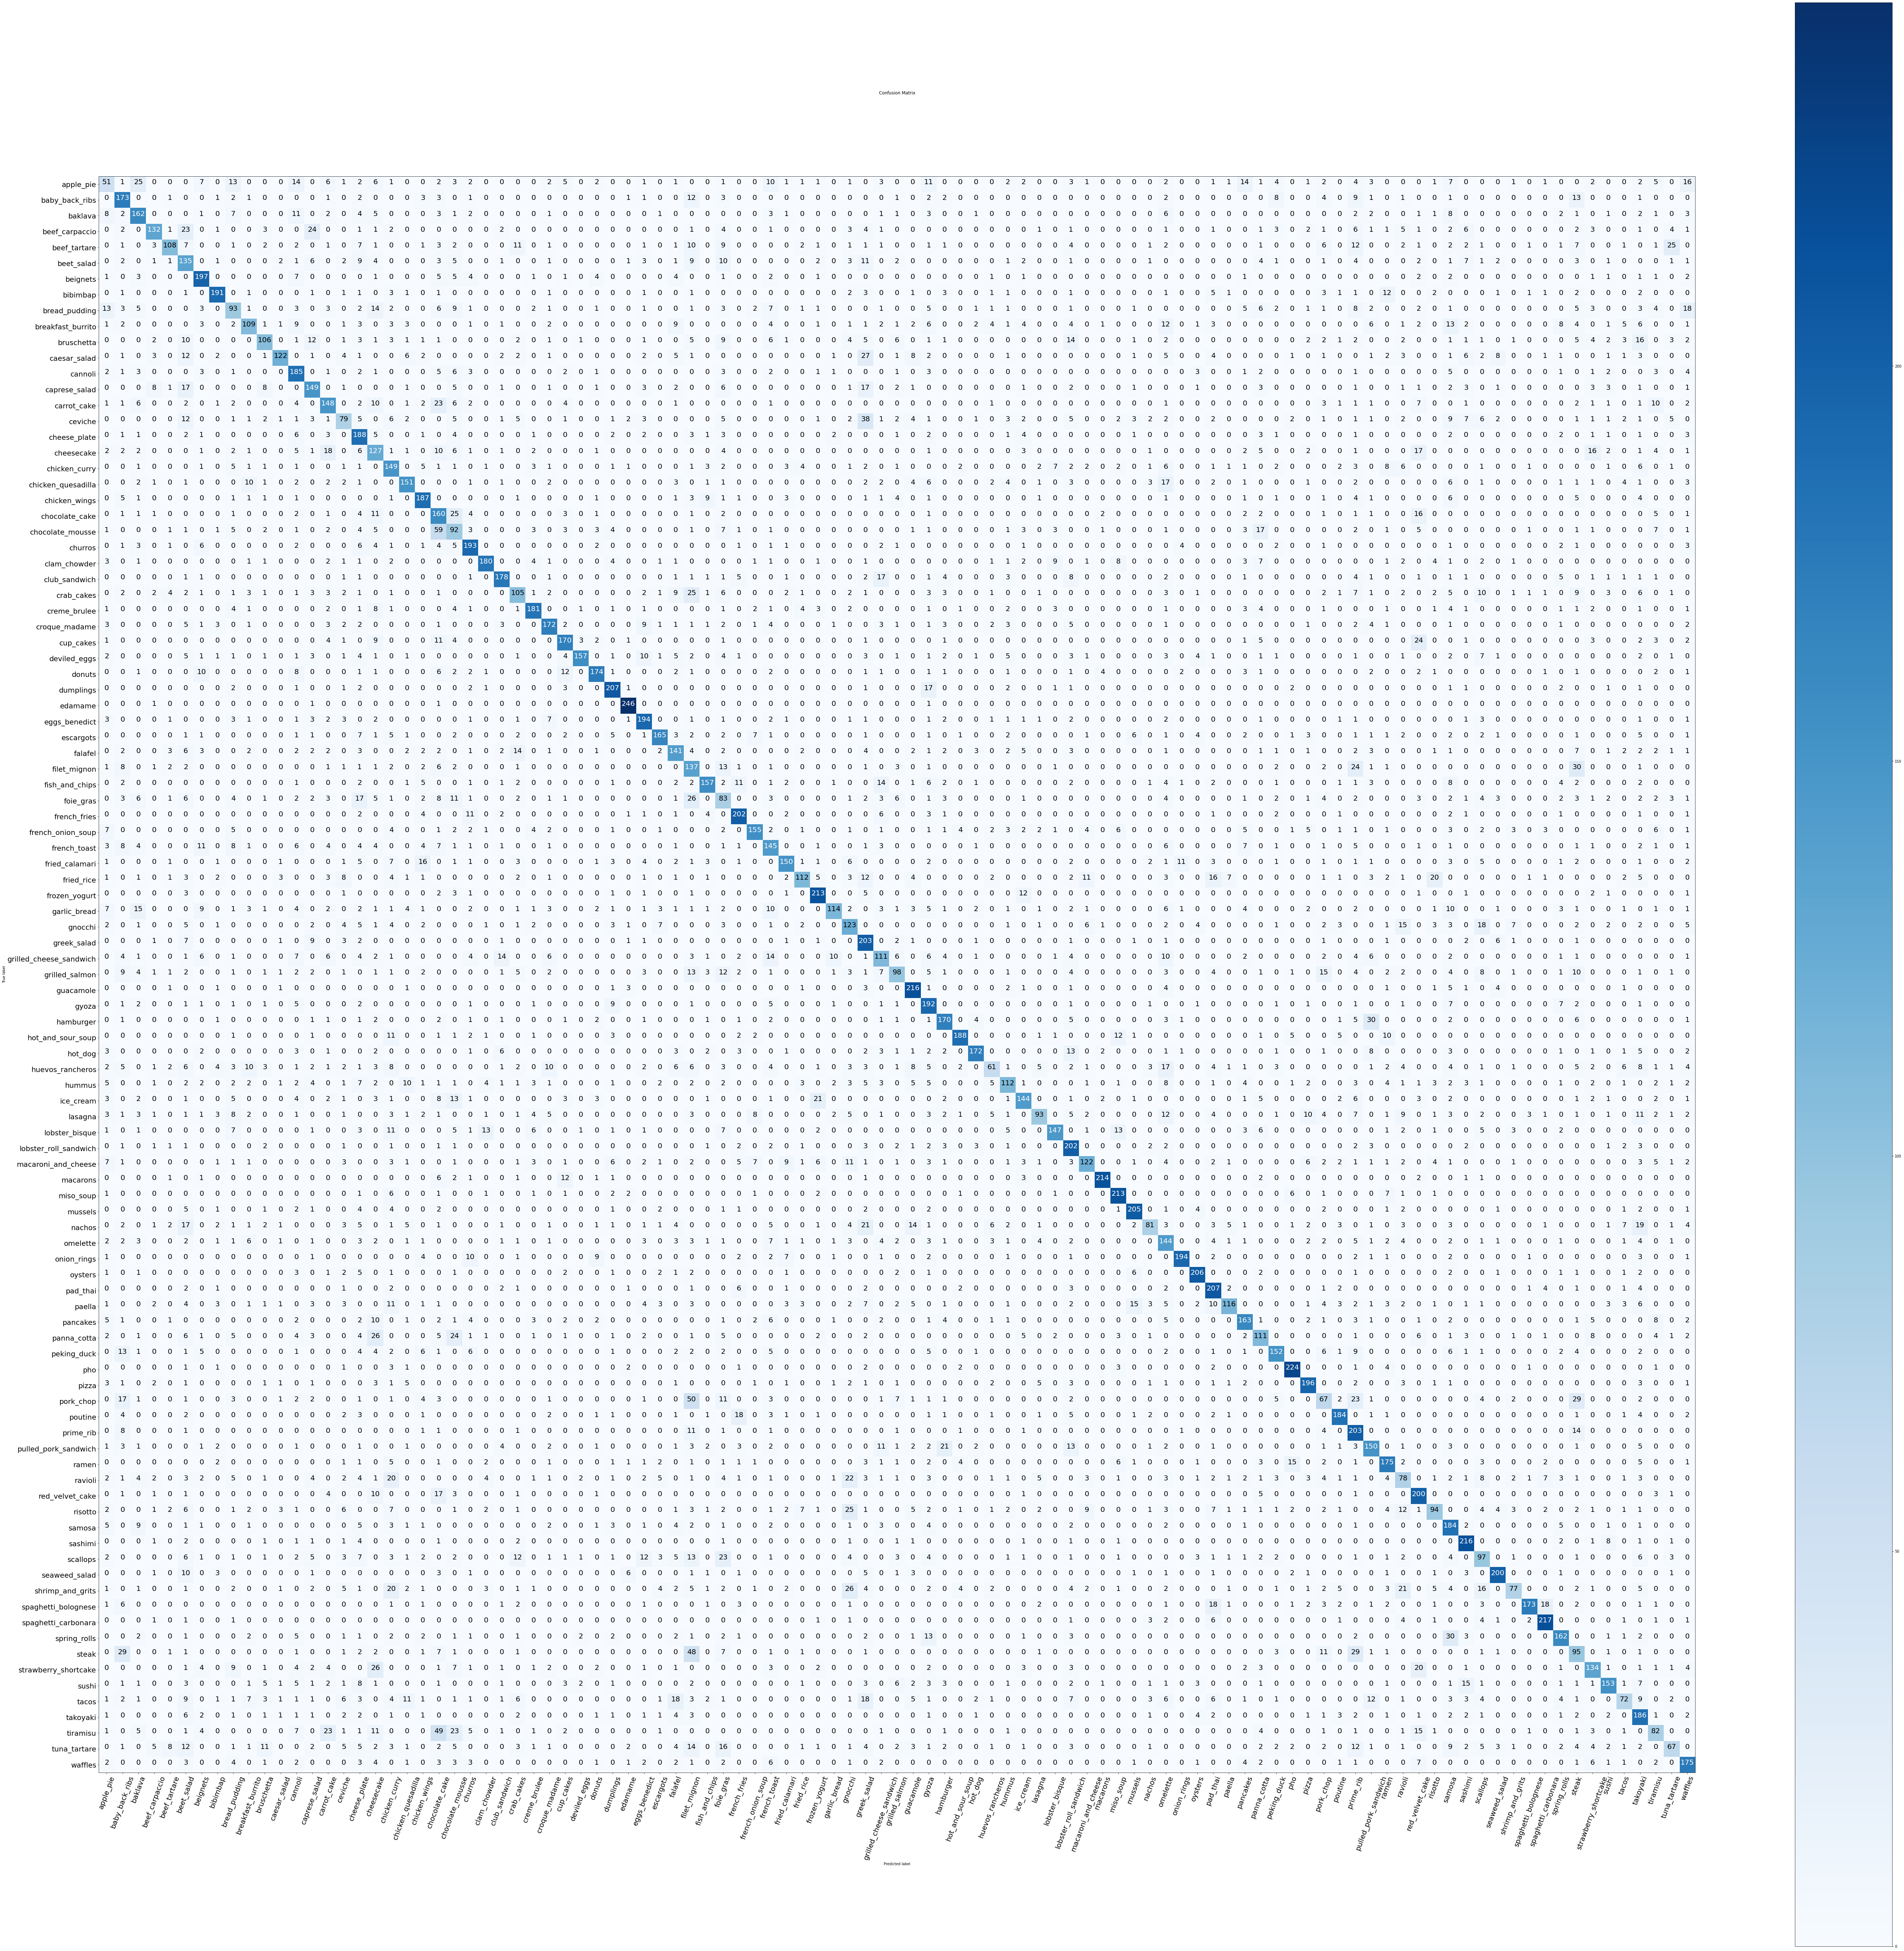

In [49]:
make_confusion_matrix(
    y_true = y_labels,
    y_pred = pred_classes,
    classes = class_names,
    figsize = (100, 100),
    text_size = 20,
    savefig = True
)

#### Create a classification report

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [51]:
# Get a dictionary of classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report

<function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>

In [52]:
classification_report_dict['99']['f1-score']

0.35356200527704484

#### Plot all classes F1-scores

In [53]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break   # stop once we get to accuracy key
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [54]:
# Turn f1-score into dataframe for visualization
import pandas as pd

f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

In [55]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

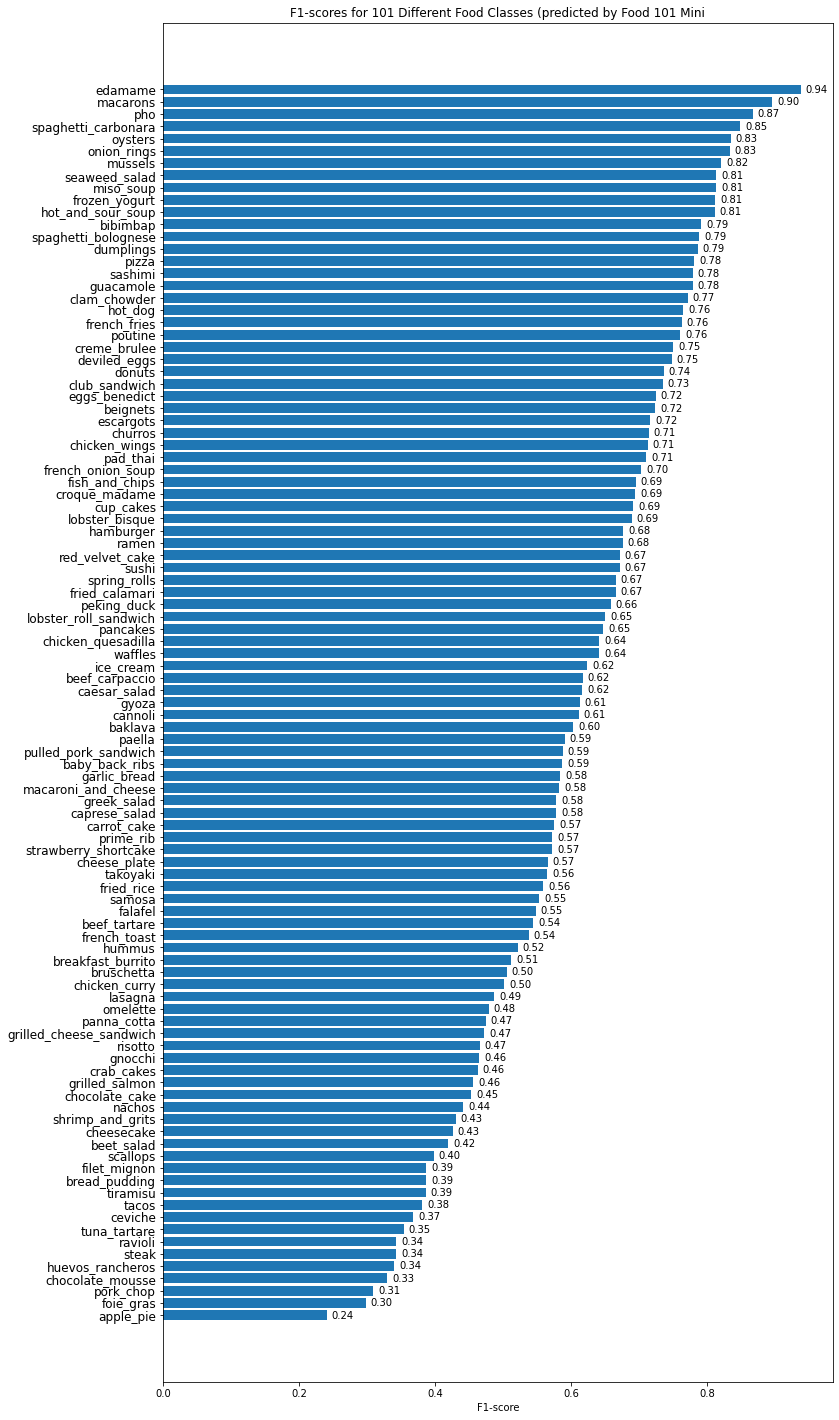

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'], fontsize=12)
ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 Different Food Classes (predicted by Food 101 Mini')
ax.invert_yaxis();  # reverse the order of the plot

rects = ax.patches

for rect in rects:
  x_value = rect.get_width()
  y_value = rect.get_y() + rect.get_height() / 2

  space = 5
  ha = 'left'

  label = '{:.2f}'.format(x_value)

  plt.annotate(
      label,
      (x_value, y_value),
      xytext=(space, 0),
      textcoords='offset points',
      va='center',
      ha=ha
  )

### Visualizing predictions on test images

Create a function that load and preprocess images, it needs to:
* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scale the image to get all pixel values between 0 & 1 (if necessary)

In [79]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Read in an image from filename, turns it into a tensor and reshapes into 
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    img_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255
  else:
    return img

Write some code to visualize images, their target label and our model's predictions.

1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

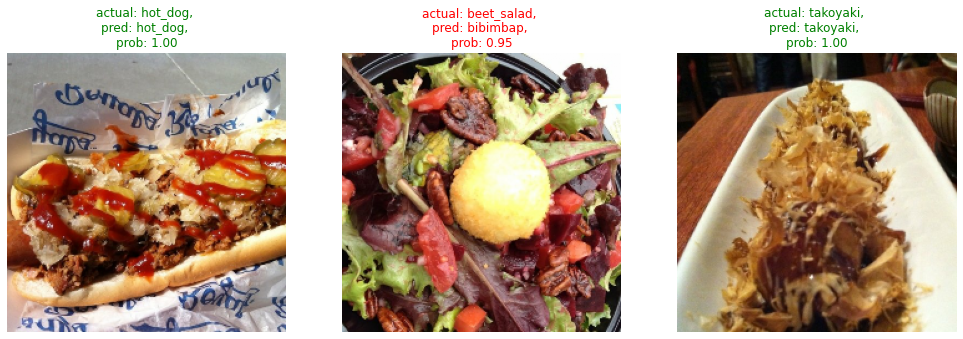

In [92]:
# Make predictions on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image(s) from a random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + class_name + '/' + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)  # match the image shape to the training data image shape
  pred_prob = model.predict(img_expanded)  # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it to class_names list

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)  # normalize the image 
  if class_name == pred_class:  # if predicted class matches truth class, make text green
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f"actual: {class_name}, \npred: {pred_class}, \nprob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

* A good way to inspect your model's performance is to view the wrong predictions with the highest prediction probability (or highest loss)
* Can reveal insights such as:
  * Data issues (wrong labels, e.g. model is right, label is wrong)
  * Confusing classes (get better/more diverse data)

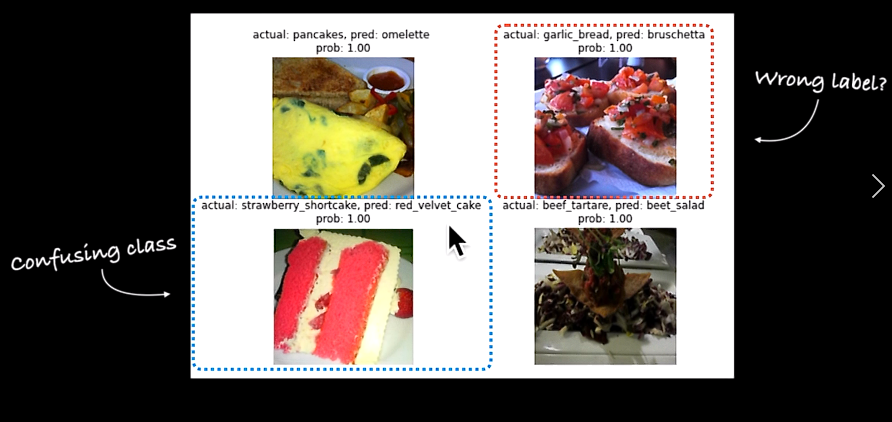

To find out where our model is most wrong, write some code to find out the following:
1. Get all of the image file paths in the test dataset using `list_files()` method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame base on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction

In [97]:
# 1. Get all of the image filepaths in the test dataset
filepaths = []
for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [99]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd

pred_df = pd.DataFrame({'img_path': filepaths,
                       'y_true': y_labels,
                       'y_pred': pred_classes,
                       'pred_conf': pred_probs.max(axis=1), # get the max prediction probability value
                        'y_true_classname': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]
})

pred_df[:10]

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   
5  b'/content/101_food_classes_10_percent/test/ap...       0      61   
6  b'/content/101_food_classes_10_percent/test/ap...       0      29   
7  b'/content/101_food_classes_10_percent/test/ap...       0       0   
8  b'/content/101_food_classes_10_percent/test/ap...       0      85   
9  b'/content/101_food_classes_10_percent/test/ap...       0       0   

   pred_conf y_true_classname       y_pred_classname  
0   0.847419        apple_pie                  gyoza  
1   0.964017        apple_pie              apple_pie  
2   0.959259        apple_pie              apple_pie  
3   0.658607        apple_pie   pulled_pork_sandwich  
4   0.367900        apple_pie              prime_rib  
5   0.456755        apple_pie  lobster_roll_sandwich  
6   0.611242        apple_pie              cup_cakes  
7   0.473133        apple_pie              apple_pie  
8   0.245396        apple_pie                 samosa  
9   0.724389        apple_pie              apple_pie

In [101]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847419        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367900        apple_pie             prime_rib         False

In [103]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

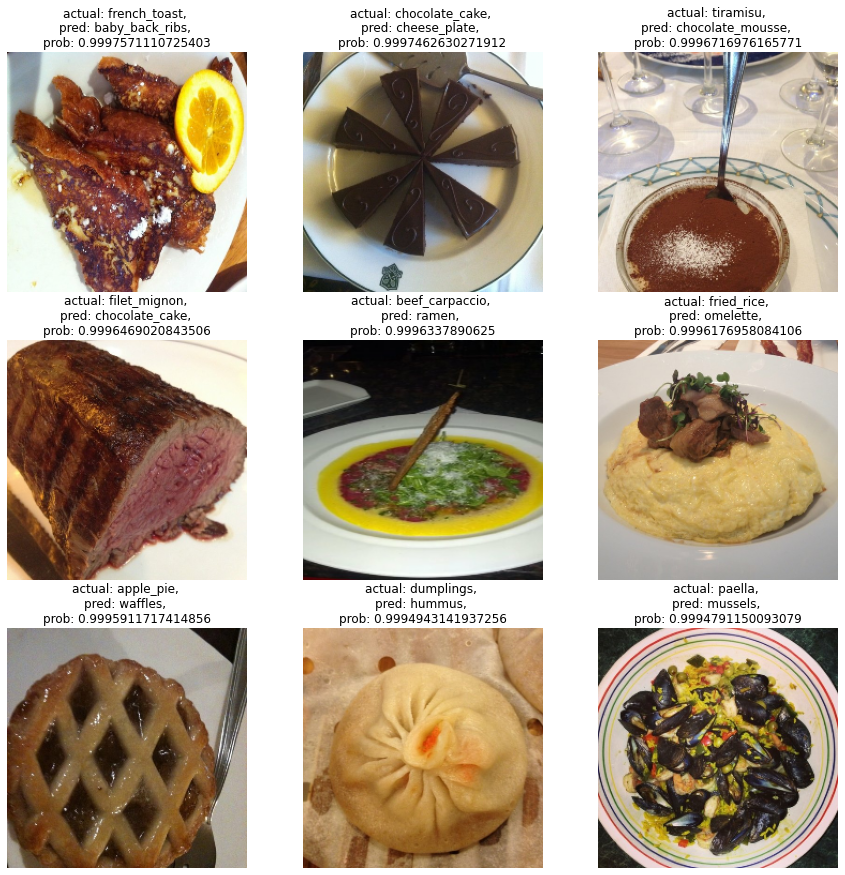

In [113]:
# 5. Visualize the test data samples which have the wrong predictions but highest prediction probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15, 15))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # show only interested parameters
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, \npred: {y_pred_classname}, \nprob: {pred_prob}")
  plt.axis(False);

## Making prediction on custom images

In [114]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data('custom_food_images.zip')

--2022-10-08 22:31:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  70.2MB/s    in 0.2s    

2022-10-08 22:31:43 (70.2 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [115]:
# Get the custom images filepaths
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg']

In [121]:
!wget https://i.pinimg.com/564x/4d/5d/98/4d5d981b39836c44755b4f9414ab8de1.jpg
!wget https://i.pinimg.com/564x/e4/58/58/e458586e87536ce2cb060529c13c80fb.jpg

--2022-10-08 22:40:15--  https://i.pinimg.com/564x/4d/5d/98/4d5d981b39836c44755b4f9414ab8de1.jpg
Resolving i.pinimg.com (i.pinimg.com)... 104.18.14.176, 104.18.15.176, 2606:4700::6812:eb0, ...
Connecting to i.pinimg.com (i.pinimg.com)|104.18.14.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64317 (63K) [image/jpeg]
Saving to: ‘4d5d981b39836c44755b4f9414ab8de1.jpg’

4d5d981b39836c44755 100%[===================>]  62.81K  --.-KB/s    in 0.01s   

2022-10-08 22:40:15 (6.17 MB/s) - ‘4d5d981b39836c44755b4f9414ab8de1.jpg’ saved [64317/64317]

--2022-10-08 22:40:15--  https://i.pinimg.com/564x/e4/58/58/e458586e87536ce2cb060529c13c80fb.jpg
Resolving i.pinimg.com (i.pinimg.com)... 104.18.14.176, 104.18.15.176, 2606:4700::6812:eb0, ...
Connecting to i.pinimg.com (i.pinimg.com)|104.18.14.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148384 (145K) [image/jpeg]
Saving to: ‘e458586e87536ce2cb060529c13c80fb.jpg’

e458586e87536ce2cb0 100%[

In [123]:
def predictme(filename):
  img = load_and_prep_image(filename, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, \nprob: {pred_prob.max():.2f}")
  plt.axis(False)

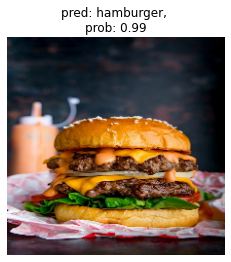

In [124]:
predictme('4d5d981b39836c44755b4f9414ab8de1.jpg')

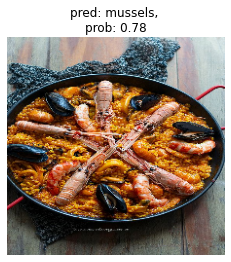

In [126]:
predictme('e458586e87536ce2cb060529c13c80fb.jpg')

--2022-10-08 22:44:23--  https://i.pinimg.com/564x/f2/96/7b/f2967b8b5e70c45989e37748be68918e.jpg
Resolving i.pinimg.com (i.pinimg.com)... 146.75.36.84, 2a04:4e42:79::84
Connecting to i.pinimg.com (i.pinimg.com)|146.75.36.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71602 (70K) [image/jpeg]
Saving to: ‘f2967b8b5e70c45989e37748be68918e.jpg’

f2967b8b5e70c45989e 100%[===================>]  69.92K  --.-KB/s    in 0.01s   

2022-10-08 22:44:23 (4.79 MB/s) - ‘f2967b8b5e70c45989e37748be68918e.jpg’ saved [71602/71602]



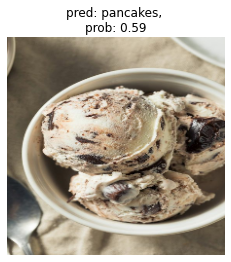

In [127]:
!wget https://i.pinimg.com/564x/f2/96/7b/f2967b8b5e70c45989e37748be68918e.jpg
predictme('f2967b8b5e70c45989e37748be68918e.jpg')

--2022-10-08 22:45:29--  https://i.pinimg.com/564x/b7/d6/54/b7d654fea799d61f381cbed8b7abd486.jpg
Resolving i.pinimg.com (i.pinimg.com)... 146.75.32.84, 2a04:4e42:79::84
Connecting to i.pinimg.com (i.pinimg.com)|146.75.32.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70821 (69K) [image/jpeg]
Saving to: ‘b7d654fea799d61f381cbed8b7abd486.jpg’

b7d654fea799d61f381 100%[===================>]  69.16K  --.-KB/s    in 0.01s   

2022-10-08 22:45:29 (5.21 MB/s) - ‘b7d654fea799d61f381cbed8b7abd486.jpg’ saved [70821/70821]



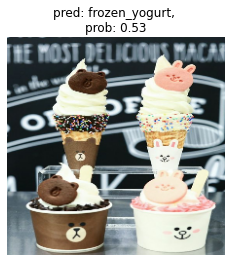

In [128]:
!wget https://i.pinimg.com/564x/b7/d6/54/b7d654fea799d61f381cbed8b7abd486.jpg
predictme('b7d654fea799d61f381cbed8b7abd486.jpg')

--2022-10-08 22:46:10--  https://i.pinimg.com/564x/f3/7b/15/f37b15c940e80b90ed6e9e27d6c732a3.jpg
Resolving i.pinimg.com (i.pinimg.com)... 146.75.32.84, 2600:1408:c400:11::17cd:6b5a, 2600:1408:c400:11::17cd:6b52
Connecting to i.pinimg.com (i.pinimg.com)|146.75.32.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44395 (43K) [image/jpeg]
Saving to: ‘f37b15c940e80b90ed6e9e27d6c732a3.jpg’

f37b15c940e80b90ed6 100%[===================>]  43.35K  --.-KB/s    in 0.01s   

2022-10-08 22:46:10 (3.44 MB/s) - ‘f37b15c940e80b90ed6e9e27d6c732a3.jpg’ saved [44395/44395]



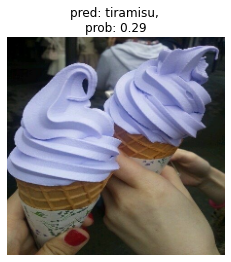

In [129]:
!wget https://i.pinimg.com/564x/f3/7b/15/f37b15c940e80b90ed6e9e27d6c732a3.jpg
predictme('f37b15c940e80b90ed6e9e27d6c732a3.jpg')

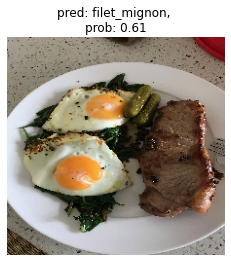

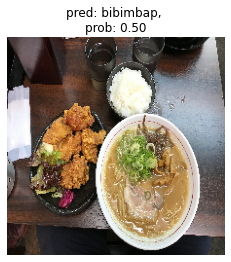

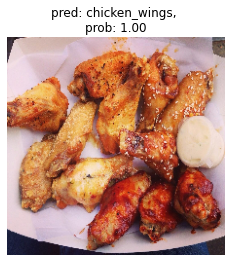

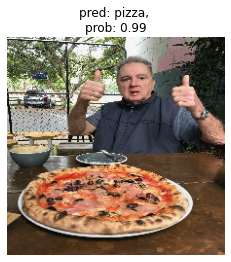

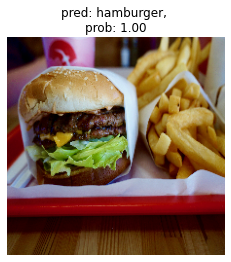

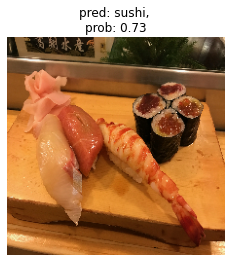

In [120]:
# Make predictions and plot custom images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, \nprob: {pred_prob.max():.2f}")
  plt.axis(False)